In [12]:
import os;os.environ["TF_USE_LEGACY_KERAS"]="1"

In [13]:
from distiller import Distiller, WarmUpCosine
from tensorflow import keras
import tensorflow as tf

from preprocessing import dataset_preprocessing, mixup
from custom_mobilenet_v2 import MobileNet_v2
from plotting import  plot_training_history
import matplotlib.pyplot as plt
import numpy as np

In [14]:
BATCH_SIZE = 16
IMAGE_SIZE = 224
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
EPOCHS = 5000
DROPOUT = 0.2
SCALE = 127.5
OFFSET = -1
FREEZING_PERCENTAGE = 1
INIT_LR = 0.003


PATH = "..\coffe_dataset"
TEACHER_NAME = "01_mobilenet_v2_0.35_224"
STUDENT_NAME = "01_mobilenet_v2_0.35_224_distilled"

In [15]:
dataset = keras.utils.image_dataset_from_directory(PATH,
                                                   shuffle = True,
                                                   batch_size = BATCH_SIZE,
                                                   image_size = (IMAGE_SIZE, IMAGE_SIZE))

class_names = dataset.class_names
number_classes = len(class_names)

training_dataset, validation_dataset, testing_dataset = dataset_preprocessing(dataset,
                                                                              train_size=0.60,
                                                                              validation_size=0.2, 
                                                                              augmentation_flag = True, 
                                                                              rescaling_flag = True, 
                                                                              prefetch_flag = True, 
                                                                              scale = SCALE, 
                                                                              offset = OFFSET)



Found 1379 files belonging to 9 classes.


In [16]:
teacher_model = keras.models.load_model('saved_models/' + TEACHER_NAME + '.keras')

teacher_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

teacher_model.evaluate(testing_dataset)

C:\Users\ALESSANDRO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tf_keras\src\backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


18/18 [==============================] - 25s 129ms/step - loss: 0.2282 - sparse_categorical_accuracy: 0.9236


[0.22815720736980438, 0.9236111044883728]

In [17]:
student_model = MobileNet_v2(input_shape=INPUT_SHAPE, alpha=0.35, num_classes=number_classes, dropout=DROPOUT, minimization=True)

student_model.summary(show_trainable=True)

Model: "model_1"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            Y          
                                                                                                             
 conv2d_29 (Conv2D)          (None, 112, 112, 16)         432       ['input_2[0][0]']             Y          
                                                                                                             
 batch_normalization_43 (Ba  (None, 112, 112, 16)         64        ['conv2d_29[0][0]']           Y          
 tchNormalization)                                                                                           
                                                                                                       

In [18]:
dataset_num_train_examples = len(training_dataset)*BATCH_SIZE
steps_per_epoch = dataset_num_train_examples // BATCH_SIZE
total_steps = steps_per_epoch * EPOCHS
warmup_steps = 195000

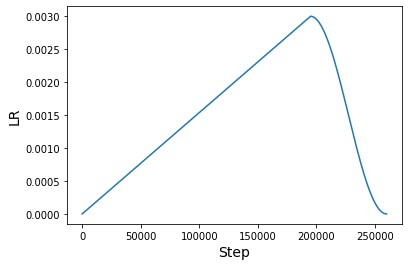

In [19]:
lr_schedule = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = lr_schedule(np.arange(0,total_steps))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [20]:
mixup_training_dataset = training_dataset.map(mixup, num_parallel_calls=tf.data.AUTOTUNE)

In [21]:
distiller = Distiller(student=student_model, teacher= teacher_model, alpha=0.1, temperature=10)

distiller.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss = keras.losses.KLDivergence()
)


In [22]:
history = distiller.fit(mixup_training_dataset, epochs= EPOCHS, validation_data= validation_dataset)

Epoch 1/5000


C:\Users\ALESSANDRO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tf_keras\src\backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


52/52 [==============================] - 111s 1s/step - sparse_categorical_accuracy: 0.2112 - student_loss: 1.9800 - distillation_loss: 3.5571e-04 - val_sparse_categorical_accuracy: 0.2046 - val_student_loss: 2.1335
Epoch 2/5000
52/52 [==============================] - 31s 605ms/step - sparse_categorical_accuracy: 0.2125 - student_loss: 1.9796 - distillation_loss: 3.5076e-04 - val_sparse_categorical_accuracy: 0.2046 - val_student_loss: 2.1288
Epoch 3/5000
52/52 [==============================] - 32s 605ms/step - sparse_categorical_accuracy: 0.2222 - student_loss: 1.9525 - distillation_loss: 3.5397e-04 - val_sparse_categorical_accuracy: 0.2046 - val_student_loss: 2.1204
Epoch 4/5000
52/52 [==============================] - 32s 604ms/step - sparse_categorical_accuracy: 0.2430 - student_loss: 1.9540 - distillation_loss: 3.5283e-04 - val_sparse_categorical_accuracy: 0.2046 - val_student_loss: 1.9488
Epoch 5/5000
52/52 [==============================] - 33s 634ms/step - sparse_categorical_a

In [23]:
#plot_training_history(history)

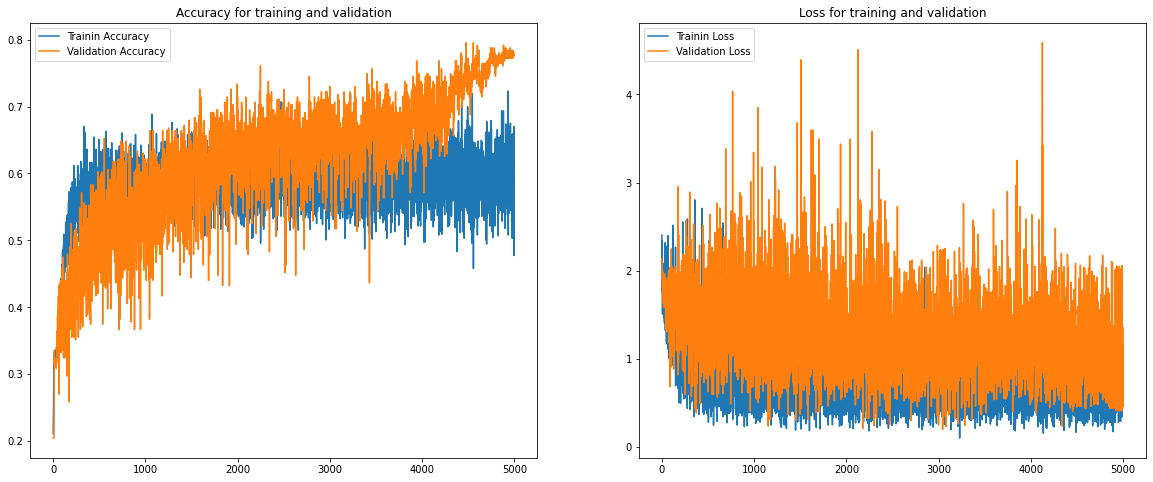

In [24]:
training_accuracy = history.history['sparse_categorical_accuracy']
validation_accuracy = history.history['val_sparse_categorical_accuracy']
training_loss = history.history['student_loss']
validation_loss = history.history['val_student_loss']

epochs_range = range(len(training_accuracy))

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, training_accuracy,   label = 'Trainin Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.legend()
plt.title('Accuracy for training and validation')

plt.subplot(1,2,2)
plt.plot(epochs_range, training_loss,   label = 'Trainin Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.legend()
plt.title('Loss for training and validation')

plt.show()

In [25]:
student_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

_, teacher_accuracy = teacher_model.evaluate(testing_dataset, verbose = 0)
_, student_accuracy = student_model.evaluate(testing_dataset, verbose = 0)
print('Teacher model accuracy: ', round(teacher_accuracy*100, 3), '%')
print('Student model accuracy: ', round(student_accuracy*100, 3), '%')


Caching the list of root modules, please wait!
Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)

(This will only be done once - type '%rehashx' to reset cache!)




C:\Users\ALESSANDRO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tf_keras\src\backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Teacher model accuracy:  92.361 %
Student model accuracy:  78.472 %


In [26]:
student_model.save('saved_models/' + STUDENT_NAME + '.keras')